# Scanning Session Ingestion

## Setup

### Connect to the database

If you are don't have your login information, contact the administrator.

Using local config file (see [01_pipeline](./01_pipeline.ipynb)):

Check out the respective elements video: https://www.youtube.com/watch?v=DLYqnj40eAM

Use this as info NB https://github.com/SFB1089/workflow-calcium-imaging/blob/main/notebooks/07-downstream-analysis-optional.ipynb


In [1]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
import datajoint as dj; dj.conn()


[2023-07-18 09:12:35,031][INFO]: Connecting tobiasr@172.26.128.53:3306
[2023-07-18 09:12:35,080][INFO]: Connected tobiasr@172.26.128.53:3306


DataJoint connection (connected) tobiasr@172.26.128.53:3306

Manual entry:

### Imports and activation

Importing schema from `adamacs.pipeline` automatically activates relevant schema.

In [2]:
import datajoint as dj
from adamacs.pipeline import subject, session, surgery, scan, event, trial, imaging
from adamacs import utility
from adamacs.ingest import behavior as ibe
from pywavesurfer import ws
import matplotlib.pyplot as plt
# check https://elements.datajoint.org/description/event/ for doc

Assign easy names for relevant tables

In [3]:
sub, lab, protocol, line, mutation, user, project, subject_genotype, subject_death = (
    subject.Subject(), subject.Lab(), subject.Protocol(), subject.Line(), 
    subject.Mutation(), subject.User(), subject.Project(), subject.SubjectGenotype(), 
    subject.SubjectDeath())

## Ingesting behavior

In [4]:
session.Session()

session_id,subject PyRat import uses this for earmark value,session_datetime
sess9FJ0W5JJ,ROS-1571,2023-07-12 00:00:00
sess9FJ0WPJZ,ROS-1571,2023-07-12 00:00:00
sess9FJ0WZC7,ROS-1571,2023-07-12 00:00:00
sess9FJ1ISOK,WEZ-8873,2023-07-13 00:00:00


In [5]:
print(event.EventType.describe())

event_type           : varchar(300)                 
---
event_type_description="" : varchar(300)                 



In [6]:
scansi = "scan9FJ0WPJZ"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0]
aux_setup_typestr = (scan.ScanInfo() & scan_key).fetch("userfunction_info")[0]



ibe.ingest_aux("sess9FJ0WPJZ","scan9FJ0WPJZ", verbose=True, aux_setup_type=aux_setup_typestr)

Number of aux-files found: 1


/home/tobiasr/miniconda3/envs/datajoint/lib/python3.8/site-packages/pywavesurfer/ws.py:46: RuntimeWarning: You are reading a WaveSurfer file version this module was not tested with: file version 1.0.6, latest version tested: 0.982
  warnings.warn('You are reading a WaveSurfer file version this module was not tested with: '


main_track_gate
shutter
bench2p_frames
bench2p_volumes
aux_cam
aux_bonsai_vis
Appearing_Checkerboard_Noise:0;Appearing_Checkerboard_Noise;-2;15;20:50;0;0;3;
Appearing_Checkerboard_Noise:0;Appearing_Checkerboard_Noise;-9;15;20:50;0;0;3;
Appearing_Checkerboard_Noise:0;Appearing_Checkerboard_Noise;-5;15;20:50;0;0;3;
Appearing_Checkerboard_Noise:0;Appearing_Checkerboard_Noise;3;15;20:50;0;0;3;
Appearing_Checkerboard_Noise:0;Appearing_Checkerboard_Noise;8;15;20:50;0;0;3;
Appearing_Checkerboard_Noise:90;Appearing_Checkerboard_Noise;0;30;20:50;90;0;3;
Appearing_Checkerboard_Noise:90;Appearing_Checkerboard_Noise;0;4;20:50;90;0;3;
Appearing_Checkerboard_Noise:0;Appearing_Checkerboard_Noise;-6;15;20:50;0;0;3;
Appearing_Checkerboard_Noise:90;Appearing_Checkerboard_Noise;0;15;20:50;90;0;3;
Appearing_Checkerboard_Noise:90;Appearing_Checkerboard_Noise;0;19;20:50;90;0;3;
Appearing_Checkerboard_Noise:0;Appearing_Checkerboard_Noise;-17;15;20:50;0;0;3;
Appearing_Checkerboard_Noise:0;Appearing_Checkerboa

In [ ]:
auxpath = (event.BehaviorRecording.File() & scan_key).fetch('filepath')
print(auxpath)

In [ ]:
curr_file = ws.loadDataFile(filename=auxpath[0], format_string='double' )
sweep = "sweep_2027"

In [ ]:
# from element_interface.utils import find_full_path
# from adamacs.paths import get_experiment_root_data_dir
# bpod_path_relative = (event.BehaviorRecording.File() & scan_key).fetch('filepath')
# harp_paths = list(find_full_path(
#             get_experiment_root_data_dir(), bpod_path_relative
#         ).parent.glob)

In [8]:
(event.Event & scan_key & 'event_type LIKE "%Appearing_Checkerboard_Noise;-12;15;20:50;0;0;3;%"')

session_id,scan_id,event_type,event_start_time (second) relative to recording start,event_end_time (second) relative to recording start
sess9FJ0WPJZ,scan9FJ0WPJZ,Appearing_Checkerboard_Noise:0;Appearing_Checkerboard_Noise;-12;15;20:50;0;0;3;,182.593,183.592
sess9FJ0WPJZ,scan9FJ0WPJZ,Appearing_Checkerboard_Noise:0;Appearing_Checkerboard_Noise;-12;15;20:50;0;0;3;,264.193,265.192
sess9FJ0WPJZ,scan9FJ0WPJZ,Appearing_Checkerboard_Noise:0;Appearing_Checkerboard_Noise;-12;15;20:50;0;0;3;,454.193,455.203
sess9FJ0WPJZ,scan9FJ0WPJZ,Appearing_Checkerboard_Noise:0;Appearing_Checkerboard_Noise;-12;15;20:50;0;0;3;,791.192,792.193
sess9FJ0WPJZ,scan9FJ0WPJZ,Appearing_Checkerboard_Noise:0;Appearing_Checkerboard_Noise;-12;15;20:50;0;0;3;,894.192,895.192
sess9FJ0WPJZ,scan9FJ0WPJZ,Appearing_Checkerboard_Noise:0;Appearing_Checkerboard_Noise;-12;15;20:50;0;0;3;,1138.19,1139.21
sess9FJ0WPJZ,scan9FJ0WPJZ,Appearing_Checkerboard_Noise:0;Appearing_Checkerboard_Noise;-12;15;20:50;0;0;3;,1439.2,1440.21
sess9FJ0WPJZ,scan9FJ0WPJZ,Appearing_Checkerboard_Noise:0;Appearing_Checkerboard_Noise;-12;15;20:50;0;0;3;,1650.2,1651.19
sess9FJ0WPJZ,scan9FJ0WPJZ,Appearing_Checkerboard_Noise:0;Appearing_Checkerboard_Noise;-12;15;20:50;0;0;3;,1894.19,1895.19
sess9FJ0WPJZ,scan9FJ0WPJZ,Appearing_Checkerboard_Noise:0;Appearing_Checkerboard_Noise;-12;15;20:50;0;0;3;,1985.2,1986.19


In [10]:
import numpy as np

analog_scans = curr_file[sweep]['analogScans']
analog_labels = curr_file['header']['AIChannelNames']
digital_labels = curr_file['header']['DIChannelNames']
sr = curr_file['header']['AcquisitionSampleRate'][0][0]
digital_scans = ibe.demultiplex(curr_file[sweep]['digitalScans'][0], np.shape(digital_labels)[0])
step = 10

# Plotting analogScans
# plt.figure(figsize=(12, 6))
# plt.title("Analog Scans")

# Creating subplots
fig, axes = plt.subplots(nrows=analog_scans.shape[0], ncols=1, figsize=(50, 10))

# Plotting analogScans
axes[0].set_title(f"Analog Scans - Every {step}th Sample")
for i in range(analog_scans.shape[0]):
     axes[i].plot(analog_scans[i][::step], label=f"AI {analog_labels[i]}")
     axes[i].legend()
     axes[i].set_xlabel("Sample Index")
     axes[i].set_ylabel("Signal")

plt.show()


# Creating subplots
fig, axes = plt.subplots(nrows=digital_scans.shape[0], ncols=1, figsize=(50, 10))

# Plotting analogScans
axes[0].set_title(f"Digital Scans - Every {step}th Sample")
for i in range(digital_scans.shape[0]):
     axes[i].plot(digital_scans[i][::step], label=f"DI {digital_labels[::-1][i]}")
     axes[i].set_xlabel("Sample Index")
     axes[i].set_ylabel("Signal")
     axes[i].legend()
plt.show()


NameError: name 'curr_file' is not defined

NameError: name 'curr_file' is not defined

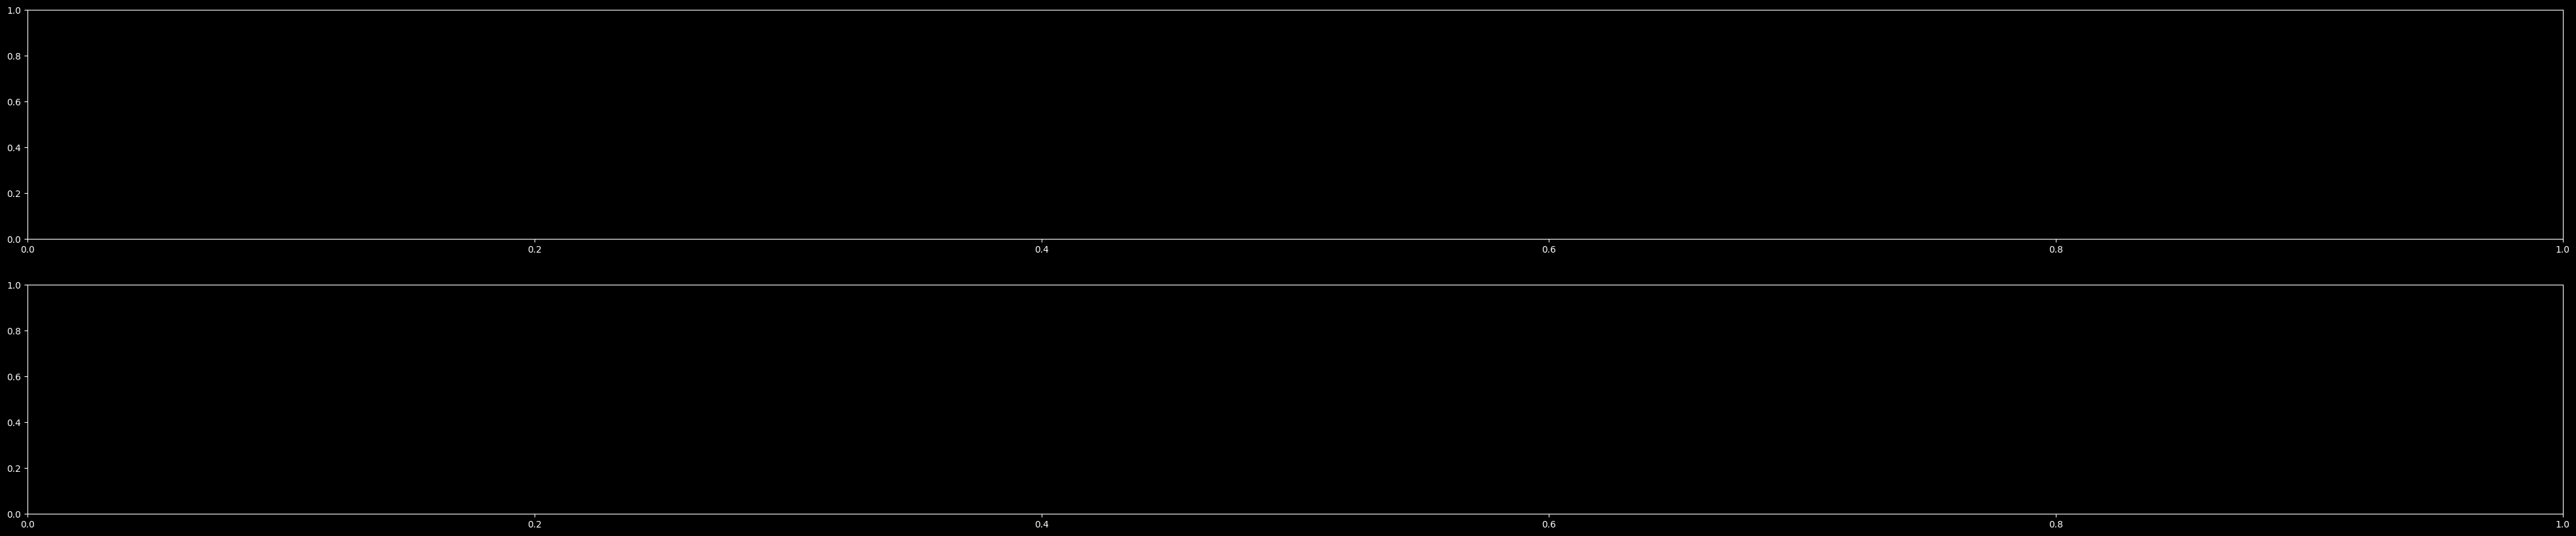

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(50, 10))
sr = curr_file['header']['AcquisitionSampleRate'][0][0]
# Plotting analogScans
axes[0].set_title(f"Analog Scans - Every {step}th Sample")
# for i in range(analog_scans.shape[0]):
i = 0
axes[i].plot(np.abs(analog_scans[i][::step]), label=f"AI {analog_labels[i]}")
axes[i].legend()
axes[i].set_xlabel("Sample Index")
axes[i].set_ylabel("Signal")

if i == 0:
     onsets = (event.Event & scan_key & "event_type = 'aux_bonsai_vis'").fetch('event_start_time') * sr / step
     offsets = (event.Event & scan_key & "event_type = 'aux_bonsai_vis'").fetch('event_end_time') * sr / step
     for xc in onsets:
          axes[i].axvline(x=xc, color = 'r')
     for xc in offsets:
          # axes[i].axvline(x=xc, color = 'r')
          axes[i].axvline(x=xc, color = 'w')
     

In [ ]:
ibe.get_timestamps(np.abs(analog_scans[i]), sr, 1)

In [ ]:
event.Event & scan_key

In [ ]:
(event.Event & scan_key & "event_type = 'aux_bonsai_vis'").fetch('event_start_time')
# auxgatetimestamp_end = (event.Event()  &  "event_type='main_track_gate'" &  scanquery ).fetch('event_end_time')

In [ ]:
dj.Diagram(trial) + dj.Diagram(event) +100


In [ ]:
surgery

In [ ]:
dj.Diagram(subject.Subject) + dj.Diagram(event) + dj.Diagram(scan)

In [ ]:
fp = event.BehaviorRecording.File().fetch('filepath')
print(fp)


In [ ]:
scan.Scan()

In [ ]:
event.AlignmentEvent()

In [ ]:
trial.Trial()

In [ ]:
dj.Diagram(event)

In [ ]:
session.Session * session.SessionDirectory

In [ ]:
key='scan9FF6U114'
(scan.Scan & f'scan_id=\"{key}\"')

In [ ]:
scan.Scan()

`CB DEV NOTE:` In demo file, there are no `scan.motor_position_at_zero` values. Set to 0 here to avoid downstream type errors when adding. Future would should set these to null when not present and revise downstream code.

In [ ]:
scan.ScanInfo()

In [ ]:
scan.ScanInfo.Field()

Note the relative path below:

In [ ]:
scan.ScanInfo.ScanFile()